In [1]:
password = ""

In [2]:
import mysql.connector
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import ta

In [3]:
def getPriceData(ticker, initial_date, period, db):
    ini_date = datetime.datetime.strptime(initial_date, "%d-%m-%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    # query = 'SELECT {} FROM {} WHERE ticker=%s AND data_inici>=%s AND data_inici < %s'.format(columns, "preus") # string formatting method

    db.execute("SELECT * FROM preus " 
               "WHERE ticker=%s AND data_inici>=%s AND data_inici < %s", (ticker, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('ticker', 'data_inici', 'data_final', 'open', 'high', 'low', 'close', 'volume'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_final'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)
    return df

In [4]:
def getCountryData(country_code, initial_date, period, db, columns=None):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute("SELECT * FROM dades_paisos WHERE"
               "id_pais=%s AND data_inici>=%s AND data_inici < %s", (country_code, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('ticker', 'data_inici', 'data_final', 'open', 'high', 'low', 'close', 'volume'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_final'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)

    return df

In [5]:
def getEventData(partial_title, db):
    title = '%' + partial_title + '%'
    
    db.execute("SELECT * FROM events " 
               "WHERE titular LIKE %s", (title,))
    
    result = db.fetchall()
    df = pd.DataFrame(result, columns=('id_event', 'titular', 'descripcio', 'data', 'tipus'))
    df['data'] = pd.to_datetime(df['data'])  # set dates to datetime64
    df.set_index('id_event', inplace=True)

    return df

In [6]:
def getImportsData0(pais_origen, pais_desti, initial_date, period, db, columns=None):
    ini_date = datetime.datetime.strptime(initial_date, "%d/%m/%Y")

    end_date = ini_date + datetime.timedelta(days=period)

    db.execute('SELECT * FROM imports WHERE id_pais_origen=%s AND id_pais_desti=%s AND data_inici>=%s AND data_inici < %s',
        (pais_origen, pais_desti, ini_date, end_date))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('ticker', 'data_inici', 'data_final', 'open', 'high', 'low', 'close', 'volume'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_final'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)

    return df

In [7]:
def getImportsData(pais_origen, pais_desti, partial_categoria, db):
    categoria = '%' + partial_categoria + '%'
    db.execute('SELECT * FROM imports WHERE id_pais_origen=%s AND id_pais_desti=%s AND categoria LIKE %s',
        (pais_origen, pais_desti, categoria))

    result = db.fetchall()
    df = pd.DataFrame(result, columns=('id_import', 'id_pais_origen', 'id_pais_desti', 'data_inici', 'data_final', 'categoria', 'quantitat', 'unitats', 'preu'))
    df['data_inici'] = pd.to_datetime(df['data_inici'])  # set dates to datetime64
    df['data_final'] = pd.to_datetime(df['data_final'])
    df.set_index('data_inici', inplace=True)

    return df

In [8]:
def trend_plot(data, d_day=None, title=''):
    adx = ta.trend.ADXIndicator(high=data["high"], low=data["low"], close=data["close"])
    macd = ta.trend.MACD(close=data["close"])
    colors = ['g' if v >= 0 else 'r' for v in macd.macd_diff()]

    apds = [mpf.make_addplot(adx.adx_pos(), type='line', panel=1, color='g', ylabel='ADX', y_on_right=True),
            mpf.make_addplot(adx.adx_neg(), type='line', panel=1, color='r', secondary_y=False),
            mpf.make_addplot(adx.adx(), type='line', panel=1, color='b', secondary_y=False),
            mpf.make_addplot(macd.macd_diff(), type='bar', panel=2, color=colors, ylabel='MACD'),
            mpf.make_addplot(macd.macd(), type='line', panel=2, color='b', secondary_y=False),
            mpf.make_addplot(macd.macd_signal(), type='line', panel=2, color='orange', secondary_y=False)]

    fig, axlist = mpf.plot(data, type='candle', addplot=apds, panel_ratios=(5,3), axtitle=title, returnfig=True)
    
    if d_day != None:
        for ax in axlist:
            ax.axvline(x=d_day, linestyle='--', color='purple')
            
    mpf.show()

In [9]:
from warnings import simplefilter

# To ignore warnings
np.seterr(divide='ignore', invalid='ignore')
simplefilter(action='ignore', category=FutureWarning)

In [10]:
# IMPORTANT: execute to open database
cnx = mysql.connector.connect(user="root", password=password, database="mercatoanalisis")
cursor = cnx.cursor()

# ADX

L'indicador ADX (Average Directional Index) serveix per mesurar com de pronunciada és una tendència i acostuma a representar-se juntament amb un indicador direccional positiu (+DI) i un indicador direccional negatiu (-DI). Quan l'indicador positiu està per sobre del negatiu considerem que hi ha una tendència alcista, i quan està per sota que hi ha una tendència baixista. Com més alt sigui el ADX més forta considerarem que és la tendència.

Els tres indicadors tenen un rang de valors entre 0 i 100. Utilitzem una finestra de 14 dies per calcular aquests tres indicadors.

Representarem el ADX en color blau, el +DI en color verd i el -DI en color vermell.


# MACD

L'indicador MACD (Moving Average Convergence/Divergence) és la differència entre una mitjana mòbil exponencial amb periode de 12 dies i una mitjana mòbil exponencial amb periode de 26 dies. S'acostuma a representar juntament amb una Linia de Senyal, que és una mitjana mòbil exponencial amb periode de 9 dies, i un histograma, que es calcula fent la diferència entre el MACD i la Linia de Senyal. Aquests indicadors oscilen sobre l'eix del 0.

Quan l'indicador MACD passa per sobre de la Linia de Senyal (quan els valors de l'histograma són positius) es considera que hi ha una tendència alcista i quan passa per sota (quan l'histograma és negatiu) es considera que hi ha una tendència baixista. Com més alta sigui la diferència entre el MACD i la Linia de Senyal més pronunciada es considera que és la tendència (i els valors de l'historiograma són més extrems).

Representarem el MACD en color blau, la Linia de Senyal en color taronja i el historiograma en color verd (si es positiu) i vermell (si és negatiu).

# Guerra d'Ucraina i preu del petroli
En els dos mesos anteriors a l'inici de la guerra observem que la tendencia del preu del petroli passa a ser a l'alça de manera força pronunciada, arribant a un pic poc després de la data d'inici de la guerra i mantenint-se més o menys estable en els mesos següents, fins a 4 mesos després de l'inici de la guerra on comença una tendencia de baixada de preu.

Així doncs, les dades semblen indicar que realment la guerra a tingut un impacte en el petroli, encarint el preu.

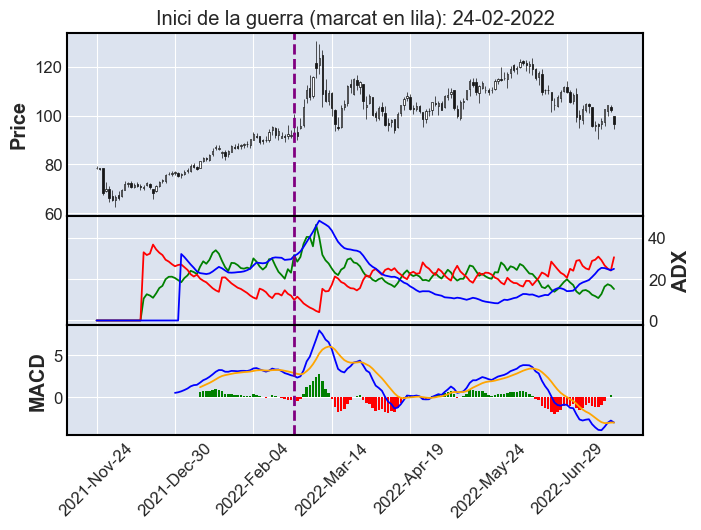

In [11]:
event = getEventData('ucraina', cursor)

if len(event['data']) == 1:
    date_war = pd.to_datetime(event['data'].values[0])
    date_plot = date_war - pd.DateOffset(months=3)
    
    oil = getPriceData('CL=F', date_plot.strftime('%d-%m-%Y'), 240, cursor)
    title = "Inici de la guerra (marcat en lila): " +  date_war.strftime('%d-%m-%Y')
    trend_plot(oil, d_day=oil.index.get_loc(date_war.strftime('%Y-%m-%d')), title=title)
    
else:
    print("No hem pogut recuperar el event de la base de dades")

# Guerra de Síria i preu del petroli
Uns 20 dies abans de l'inici de la guerra hi ha un augment pronunciat amb tendencia de pujada de preu, i aquesta tendencia es manté fins un mes i mig més fins entrar en tendencia de baixada de preus.

Així doncs, les dades semblen indicar que realment la guerra a tingut un impacte en el petroli, encarint el preu.

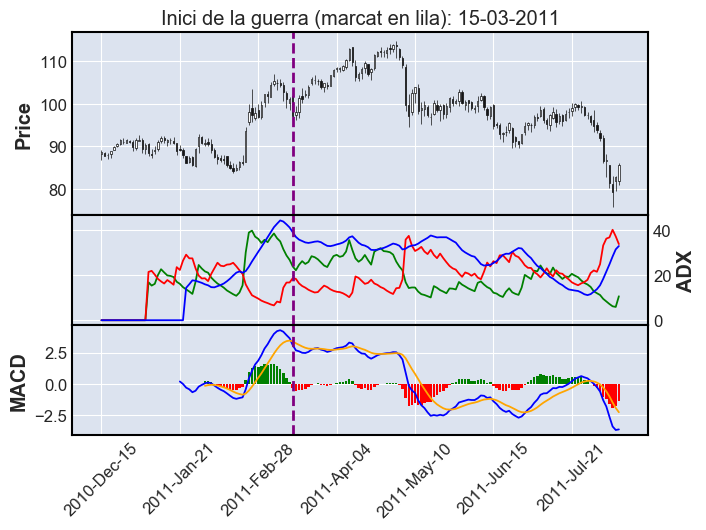

In [12]:
event = getEventData('syria', cursor)

if len(event['data']) == 1:
    date_war = pd.to_datetime(event['data'].values[0])
    date_plot = date_war - pd.DateOffset(months=3)
    
    oil = getPriceData('CL=F', date_plot.strftime('%d-%m-%Y'), 240, cursor)
    title = "Inici de la guerra (marcat en lila): " +  date_war.strftime('%d-%m-%Y')
    trend_plot(oil, d_day=oil.index.get_loc(date_war.strftime('%Y-%m-%d')), title=title)
    
else:
    print("No hem pogut recuperar el event de la base de dades")

# Sequeres i suc de taronja

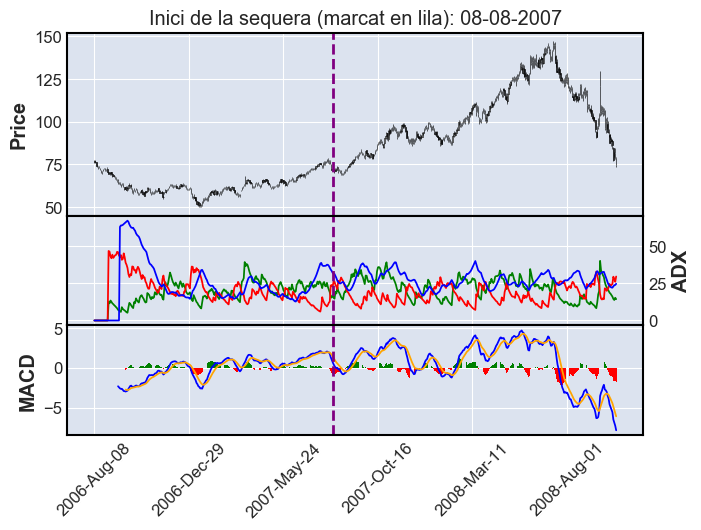

In [13]:
event = getEventData('sequera', cursor)

if len(event['data']) == 1:
    date_drought = pd.to_datetime(event['data'].values[0])
    date_plot = date_drought - pd.DateOffset(months=12)
    
    orange_juice = getPriceData('CL=F', date_plot.strftime('%d-%m-%Y'), 800, cursor)
    title = "Inici de la sequera (marcat en lila): " +  date_drought.strftime('%d-%m-%Y')
    trend_plot(orange_juice, d_day=orange_juice.index.get_loc(date_drought.strftime('%Y-%m-%d')), title=title)
    
else:
    print("No hem pogut recuperar el event de la base de dades")

# Aranzels de EEUU a ES i preu del pernil

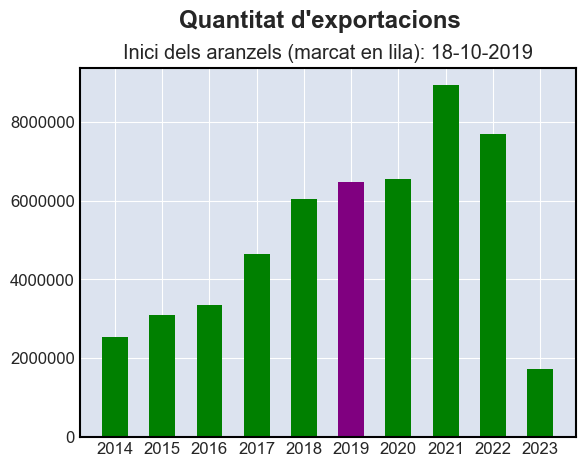

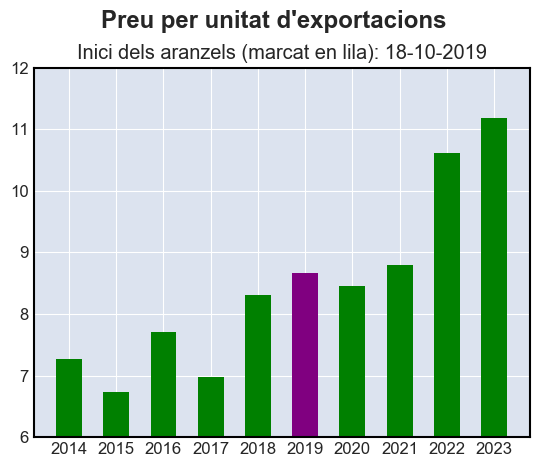

In [14]:
event = getEventData('aranzel', cursor)

if len(event['data']) == 1:
    date_aranzel = pd.to_datetime(event['data'].values[0])
    date_next_year = date_drought + pd.DateOffset(years=1)
    
    aranzels = getImportsData('ES', 'US', 'carne', cursor)
    colors = ['purple' if d.year == date_aranzel.year else 'green' for d in aranzels.index[0:10]]
    title = "Inici dels aranzels (marcat en lila): " +  date_aranzel.strftime('%d-%m-%Y')
    plt.bar(aranzels.index[0:10], aranzels['quantitat'][0:10], color =colors, width = 200)
    plt.suptitle("Quantitat d'exportacions", y=1)
    plt.title(title)
    plt.ticklabel_format(axis='y', style='plain')
    plt.show()
    
    price = aranzels['preu'][0:10] / aranzels['quantitat'][0:10]
    plt.bar(aranzels.index[0:10], price, color =colors, width = 200)
    plt.suptitle("Preu per unitat d'exportacions", y=1)
    plt.title(title)
    plt.ticklabel_format(axis='y', style='plain')
    plt.ylim([6,12])
    plt.show()
    
else:
    print("No hem pogut recuperar el event de la base de dades")



In [52]:
# IMPORTANT: execute to close database
cnx.commit()
cursor.close()

False